# Model Monitoring Example

## Marketing dataset

In [1]:
import os
import sys
import joblib
import pandas as pd
from pathlib import Path

%load_ext autoreload
%autoreload 2

sys.path.insert(1, '../src/')

from guara.modeling.supervised_modelz import *
from guara.monitoring.data_monitor import DataMonitor
from guara.monitoring.model_monitor import ModelMonitor
import utils

pd.set_option('display.max_columns', None)

# Import dataset

In [2]:
df = utils.import_s3_example_dataset('marketing').drop('ID', axis = 1)
df.head()

Baixando dataset MARKETING do S3...


,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,idade,dias_cliente,education_n,parceiro,pessoas_casa,renda_per_capta,compra_total_ano,porcentagem_compras_gold,gasto_renda,total_purchases,disc_purchases,num_compras_ano,percent_disc_compra,ticket_medio,conversao_site,cupons_aceitados
0,Graduation,Single,10.970592,0,0,58,6.455199,4.488636,6.304449,5.153292,4.488636,4.488636,1.386294,8,2.397895,4,7,0,1,63,2675,2,0,1,10.970592,764.5,0.055959,0.013064,22,1.386294,3.001869,0.136364,5.543906,0.012736,0
1,Graduation,Single,10.743869,1,1,38,2.484907,0.693147,1.945910,1.098612,0.693147,1.945910,1.098612,1,0.693147,2,5,0,0,66,2125,2,0,3,9.645300,10.5,0.251314,0.000227,4,1.098612,0.687059,0.500000,2.790093,0.002820,0
2,Graduation,Together,11.179046,0,0,26,6.056784,3.912023,4.852030,4.718499,3.091042,3.761200,0.693147,8,1.098612,10,4,0,0,55,2324,2,1,2,10.485913,367.0,0.055643,0.005112,20,0.693147,3.141136,0.050000,4.769300,0.025490,0
3,Graduation,Together,10.190432,1,0,26,2.484907,1.609438,3.044522,2.397895,1.386294,1.791759,1.098612,2,0.000000,4,6,0,0,36,2151,2,1,3,9.091895,24.0,0.099091,0.000900,6,1.098612,1.018131,0.333333,3.201632,0.004638,0
4,PhD,Married,10.973254,1,0,94,5.159055,3.784190,4.779123,3.850148,3.332205,2.772589,1.791759,5,1.386294,6,5,0,0,39,2173,4,1,3,9.874676,203.5,0.036192,0.003485,14,1.791759,2.351588,0.357143,4.472065,0.013711,0


In [3]:
# transforma colunas object pra category
# FAZER ISSO NO PIPELINE
for col in df.columns:
    if is_string_dtype(df[col]):
        df[col] = df[col].astype('category')

le = LabelEncoder()
for col in df.columns:
    if df[col].dtype.name == 'category':
        df[col] = le.fit_transform(df[col])


# Train, Val

In [4]:
train_split = 0.8
n_train_split = int(train_split*len(df))
var_resp = 'Response'

train = df.iloc[:n_train_split, :].copy()
val = df.iloc[n_train_split:, :].copy()

Xtrain = train.drop(var_resp, axis = 1)
ytrain = train[var_resp]

Xval = val.drop(var_resp, axis = 1)
yval = val[var_resp]

# Creating data monitor's baseline from training data

In [5]:
dm = DataMonitor(monitor=['input','distribution'])
dm.make_baseline(Xtrain)

Successfully created baseline for data monitor.


-----------------------------------------------------------------

# Training

## LGBM

In [6]:
print('xtrain.shape: ', Xtrain.shape, 'xval.shape: ', Xval.shape)

xtrain.shape:  (1772, 34) xval.shape:  (444, 34)


In [7]:
md = SupervisedModelz('lgbm', 'binary')

params = {

    'random_state': 501,
    'boosting_type': 'gbdt',
    'device_type': 'cpu', # 'cpu'
    'is_unbalanced':'true',
    'learning_rate': 0.01,
    'colsample_bytree': 0.7,
    'max_depth': -1,
    'n_estimators': 2000,
    'sub_sample': 0.8,
    'num_leaves': 10,
    'min_child_samples': 24,
    
 }

model = md.fit(Xtrain, Xval, ytrain, yval, params)

Path(os.path.dirname(os.getcwd())+'/artifacts/production/model').mkdir(parents=True, exist_ok=True)
joblib.dump(model, os.path.dirname(os.getcwd())+'/artifacts/production/model/model.joblib')

Treinando o modelo LGBM, objetivo BINARY... 

[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 261, number of negative: 1511
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3712
[LightGBM] [Info] Number of data points in the train set: 1772, number of used features: 33
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147291 -> initscore=-1.756007
[LightGBM] [Info] Start training from score -1.756007


Found `n_estimators` in params. Will use it instead of argument


Modelo treinado em 0.03 minutos 



['c:\\Users\\italo.avila\\OneDrive - tenbu.com.br\\Documentos\\desenvolvimentos\\python\\Tenbu\\guara/artifacts/production/model/model.joblib']

Model best iteration: 832

BINARY_LOGLOSS loss:
Train: 0.1116
Val  : 0.2444


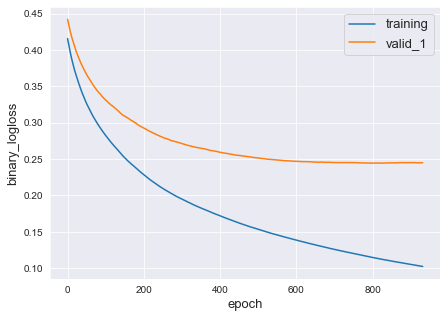

In [8]:
md.plot_train_info()

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


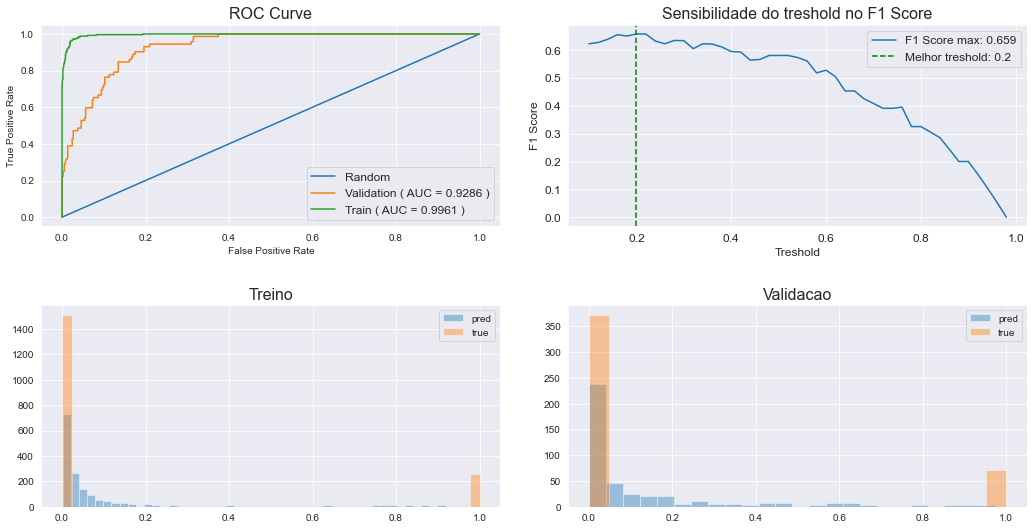

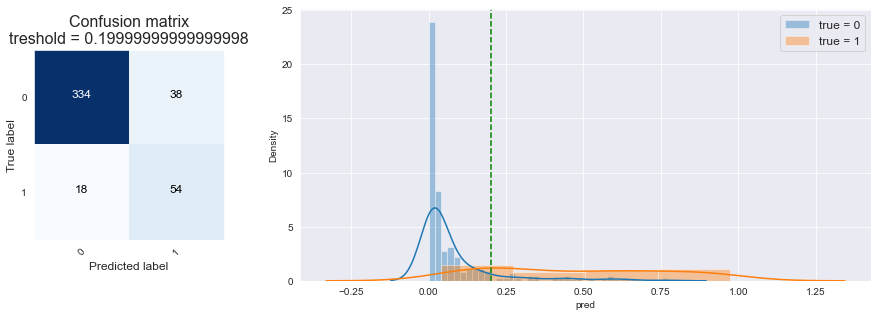


              precision    recall  f1-score   support

           0       0.95      0.90      0.92       372
           1       0.59      0.75      0.66        72

    accuracy                           0.87       444
   macro avg       0.77      0.82      0.79       444
weighted avg       0.89      0.87      0.88       444



In [9]:
ytrain_pred = md.predict(Xtrain)
yval_pred = md.predict(Xval)

md.evaluation_plots(ytrain.values, ytrain_pred, yval.values, yval_pred)

In [10]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1', 'ROC_AUC']

print('TREINO:\n')
metrics_train = md.metrics_print(ytrain.values, ytrain_pred, metrics)
print('\nVALIDACAO:\n')
metrics_val = md.metrics_print(yval.values, yval_pred, metrics)

TREINO:

|   Accuracy |   Recall |   Precision |     F1 |   ROC_AUC |
|------------|----------|-------------|--------|-----------|
|     0.9464 |   0.9885 |      0.7371 | 0.8445 |    0.9638 |

VALIDACAO:

|   Accuracy |   Recall |   Precision |     F1 |   ROC_AUC |
|------------|----------|-------------|--------|-----------|
|     0.8739 |   0.7500 |      0.5870 | 0.6585 |    0.8239 |


---

# Data Monitoring

### Initializing DataMonitor module for input schema and distribution mapping

In [11]:
dm = DataMonitor(monitor=['input','distribution'])

### Creating baseline for the initialized DataMonitor instance

In [12]:
dm.make_baseline(Xtrain)

Successfully created baseline for data monitor.


### Probing validation data

In production, the probe would be used to store API or Batch Jobs calls. In this case, we will use the validation data as a representation of the production data.

In [13]:
dm.probe(Xval,keep_ratio=1.0,shuffle_bool=True)

### Running the monitor for the data acquired from the probe

In [14]:
dm.run_monitor_with_probe_data()

Production input matches baseline from training.
------------------------------------------------------------
Production feature distribution doesn't match baseline from training.
             feature property  baseline   current     ratio  distance  \
0             Income     skew -1.243178 -0.917433  0.737974 -0.262026   
1          MntFruits     skew  0.086963  0.045984  0.528775 -0.471225   
2    MntMeatProducts      min  0.693147  0.000000  0.000000 -1.000000   
3    MntFishProducts     skew -0.046441 -0.086902  1.871232  0.871232   
4  NumDealsPurchases     skew  0.689979  0.578280  0.838113 -0.161887   

                     version  
0 2021-12-08 16:43:58.191718  
1 2021-12-08 16:43:58.191718  
2 2021-12-08 16:43:58.191718  
3 2021-12-08 16:43:58.191718  
4 2021-12-08 16:43:58.191718  
Use 'DataMonitor().dist_verification_df' to see detailed information.
------------------------------------------------------------


invalid value encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


The validation data's distribution doesn't match the distribution from the baseline. To see the distribution detailed information, we can use the dist_verification_df object from the initialized DataMonitor() class/instance.

In [15]:
dm.dist_verification_df.head(10)

,feature,property,baseline,current,ratio,distance,version
0,Income,skew,-1.243178,-0.917433,0.737974,-0.262026,2021-12-08 16:43:58.191718
1,MntFruits,skew,0.086963,0.045984,0.528775,-0.471225,2021-12-08 16:43:58.191718
2,MntMeatProducts,min,0.693147,0.000000,0.000000,-1.000000,2021-12-08 16:43:58.191718
3,MntFishProducts,skew,-0.046441,-0.086902,1.871232,0.871232,2021-12-08 16:43:58.191718
4,NumDealsPurchases,skew,0.689979,0.578280,0.838113,-0.161887,2021-12-08 16:43:58.191718
5,NumDealsPurchases,kurtosis,0.325625,0.400690,1.230526,0.230526,2021-12-08 16:43:58.191718
6,NumCatalogPurchases,max,3.367296,2.484907,0.737953,-0.262047,2021-12-08 16:43:58.191718
7,NumCatalogPurchases,skew,0.145437,0.066898,0.459977,-0.540023,2021-12-08 16:43:58.191718
8,NumCatalogPurchases,kurtosis,-1.043452,-1.294580,1.240671,0.240671,2021-12-08 16:43:58.191718
9,renda_per_capta,skew,0.083434,-0.105944,-1.269791,-2.269791,2021-12-08 16:43:58.191718


### Retrieve all warnings from the data monitor

In [16]:
dm.list_warnings()

------------------------------------------------------------
INPUT MONITOR
------------------------------------------------------------
DISTRIBUTION MONITOR
* Complain
* NumWebPurchases
* conversao_site
* percent_disc_compra
* gasto_renda
* porcentagem_compras_gold
------------------------------------------------------------
Adjustments or model retraining might be advised.
For the detailed information use DataMonitor().input_status_df (input monitor) and DataMonitor().dist_verification_df (distribution monitor).
A list containing all shifted features can be accessed with 'DataMonitor().shifted_features'.


To retrieve the shifted features, use DataMonitor().shifted_features:

In [17]:
dm.shifted_features

['Complain',
 'NumWebPurchases',
 'conversao_site',
 'gasto_renda',
 'percent_disc_compra',
 'porcentagem_compras_gold']

percentage of shifted features:

In [18]:
len(dm.shifted_features)/len(list(Xtrain.columns))

0.17647058823529413

---

# Model Monitor

## Creating model performance baseline

In [19]:
mm = ModelMonitor(objective='binary')
mm.create_performance_baseline(model=model, X=Xval, Y=yval)

In [20]:
mm.metrics_df

,model_id,version,accuracy,balanced_accuracy,precision,averaged_precision,micro_recall,macro_recall,weighted_recall,micro_f1,macro_f1,weighted_f1,roc_auc,micro_jaccard,macro_jaccard,weighted_jaccard,log_loss,neg_brier_loss
0,baseline,2021-12-08 16:44:03,0.88964,0.721326,0.755556,0.442376,0.88964,0.721326,0.88964,0.88964,0.758821,0.878838,0.721326,0.801217,0.645063,0.804134,3.811732,0.078129


## Creating new variants

During production, the variants can be developed using different algorithms and training sets. In this case, we will use the same algorithm and dataset, with different parameters, just as an example of the model monitor module usage.

In [21]:
Path(os.path.dirname(os.getcwd())+'/artifacts/variant/model').mkdir(parents=True, exist_ok=True)

In [22]:
params = {

    'random_state': 501,
    'boosting_type': 'gbdt',
    'device_type': 'cpu', # 'cpu'
    'is_unbalanced':'true',
    'learning_rate': 0.005,
    'colsample_bytree': 0.7,
    'max_depth': -1,
    'n_estimators': 2200,
    'sub_sample': 0.8,
    'num_leaves': 12,
    'min_child_samples': 24,
    
 }

variant1 = md.fit(Xtrain, Xval, ytrain, yval, params)

Treinando o modelo LGBM, objetivo BINARY... 

[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 261, number of negative: 1511
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3712
[LightGBM] [Info] Number of data points in the train set: 1772, number of used features: 33
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147291 -> initscore=-1.756007
[LightGBM] [Info] Start training from score -1.756007


Found `n_estimators` in params. Will use it instead of argument


Modelo treinado em 0.05 minutos 



In [23]:
joblib.dump(variant1, os.path.dirname(os.getcwd())+'/artifacts/variant/model/variant1.joblib')

['c:\\Users\\italo.avila\\OneDrive - tenbu.com.br\\Documentos\\desenvolvimentos\\python\\Tenbu\\guara/artifacts/variant/model/variant1.joblib']

In [24]:
params = {

    'random_state': 505,
    'boosting_type': 'gbdt',
    'device_type': 'cpu', # 'cpu'
    'is_unbalanced':'true',
    'learning_rate': 0.005,
    'colsample_bytree': 0.7,
    'max_depth': -1,
    'n_estimators': 2500,
    'sub_sample': 0.8,
    'num_leaves': 10,
    'min_child_samples': 24,
    
 }

variant2 = md.fit(Xtrain, Xval, ytrain, yval, params)

Treinando o modelo LGBM, objetivo BINARY... 

[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 261, number of negative: 1511
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3712
[LightGBM] [Info] Number of data points in the train set: 1772, number of used features: 33
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147291 -> initscore=-1.756007
[LightGBM] [Info] Start training from score -1.756007
Modelo treinado em 0.04 minutos 



In [25]:
joblib.dump(variant2, os.path.dirname(os.getcwd())+'/artifacts/variant/model/variant2.joblib')

['c:\\Users\\italo.avila\\OneDrive - tenbu.com.br\\Documentos\\desenvolvimentos\\python\\Tenbu\\guara/artifacts/variant/model/variant2.joblib']

In [26]:
params = {

    'random_state': 247,
    'boosting_type': 'gbdt',
    'device_type': 'cpu', # 'cpu'
    'is_unbalanced':'true',
    'learning_rate': 0.005,
    'colsample_bytree': 0.7,
    'max_depth': -1,
    'n_estimators': 3200,
    'sub_sample': 0.8,
    'num_leaves': 7,
    'min_child_samples': 24,
    
 }

variant3 = md.fit(Xtrain, Xval, ytrain, yval, params)

Treinando o modelo LGBM, objetivo BINARY... 

[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 261, number of negative: 1511
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3712
[LightGBM] [Info] Number of data points in the train set: 1772, number of used features: 33
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147291 -> initscore=-1.756007
[LightGBM] [Info] Start training from score -1.756007
Modelo treinado em 0.04 minutos 



In [27]:
joblib.dump(variant3, os.path.dirname(os.getcwd())+'/artifacts/variant/model/variant3.joblib')

['c:\\Users\\italo.avila\\OneDrive - tenbu.com.br\\Documentos\\desenvolvimentos\\python\\Tenbu\\guara/artifacts/variant/model/variant3.joblib']

## Inserting the new models to the performance registry

In [28]:
mm.input_variants_from_artifacts()

To check the model registry, access the ModelMonitor().model_registry object:

In [29]:
mm.model_registry

,id,model
0,baseline,<lightgbm.basic.Booster object at 0x0000022FB2...
1,variant1.joblib,<lightgbm.basic.Booster object at 0x0000022FB2...
2,variant2.joblib,<lightgbm.basic.Booster object at 0x0000022FB2...
3,variant3.joblib,<lightgbm.basic.Booster object at 0x0000022FB2...


In [30]:
mm.run_model_registry()

Model performance reference successfully updated with model registry.


To access the performance registry, access the metrics_df object from the initialized ModelMonitor() class/instance.

In [31]:
mm.metrics_df

,model_id,version,accuracy,balanced_accuracy,precision,averaged_precision,micro_recall,macro_recall,weighted_recall,micro_f1,macro_f1,weighted_f1,roc_auc,micro_jaccard,macro_jaccard,weighted_jaccard,log_loss,neg_brier_loss
0,baseline,2021-12-08 16:44:03,0.889640,0.721326,0.755556,0.442376,0.889640,0.721326,0.889640,0.889640,0.758821,0.878838,0.721326,0.801217,0.645063,0.804134,3.811732,0.078129
1,variant1.joblib,2021-12-08 16:44:03,0.894144,0.729615,0.777778,0.461420,0.894144,0.729615,0.894144,0.894144,0.768665,0.883784,0.729615,0.808554,0.655957,0.810774,3.656150,0.078934
2,variant2.joblib,2021-12-08 16:44:03,0.891892,0.722670,0.772727,0.450485,0.891892,0.722670,0.891892,0.891892,0.762015,0.880805,0.722670,0.804878,0.648780,0.806987,3.733940,0.078633
3,variant3.joblib,2021-12-08 16:44:03,0.889640,0.726927,0.744681,0.445331,0.889640,0.726927,0.889640,0.889640,0.762258,0.879841,0.726927,0.801217,0.648431,0.805029,3.811733,0.077481


The dataframe presented above contains all of the watched information for each variant.

The metrics dataframe can show less variants than expected due to very similar results. The model monitor always eliminates duplication of information and keeps the first registered model - the original variant - associated to each model monitor version.

## Selecting the best model

It's then convenient, from all of the gathered metrics, select the best model. The model monitor can do so automatically with a default scoring system which weights all mapped metrics equaly.

In [32]:
mm.select_best_model()

'variant1.joblib'

The best model with the default scoring system is presented. In some situations, however, some metrics are more important than others and the data scientist should have the freedom to modify the scoring system. Guara's model monitor empowers developers to freely change or adapt the scoring system as shown in the next cells.

## Changing metrics to be used in selection

Applications might require specific metric mapping/scoring. To account for these situations, we can select the metrics and their respective weights using the metrics_score_basis object from the initialized ModelMonitor() class/instance:

In [33]:
mm.metrics_score_basis

{'accuracy': [<function _operator.ge(a, b, /)>, 1],
 'balanced_accuracy': [<function _operator.ge(a, b, /)>, 1],
 'precision': [<function _operator.ge(a, b, /)>, 1],
 'averaged_precision': [<function _operator.ge(a, b, /)>, 1],
 'micro_recall': [<function _operator.ge(a, b, /)>, 1],
 'macro_recall': [<function _operator.ge(a, b, /)>, 1],
 'weighted_recall': [<function _operator.ge(a, b, /)>, 1],
 'micro_f1': [<function _operator.ge(a, b, /)>, 1],
 'macro_f1': [<function _operator.ge(a, b, /)>, 1],
 'weighted_f1': [<function _operator.ge(a, b, /)>, 1],
 'roc_auc': [<function _operator.ge(a, b, /)>, 1],
 'micro_jaccard': [<function _operator.ge(a, b, /)>, 1],
 'macro_jaccard': [<function _operator.ge(a, b, /)>, 1],
 'weighted_jaccard': [<function _operator.ge(a, b, /)>, 1],
 'log_loss': [<function _operator.le(a, b, /)>, 1],
 'neg_brier_loss': [<function _operator.le(a, b, /)>, 1]}

The user can access the descriptions of each metric and, from the descriptions presented, adjust the scoring system or even select the metrics that should be used in the model monitor.

In [34]:
mm.describe_metrics()

accuracy
In multilabel classification, this function computes subset accuracy:
The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
In binary classification, this function is equal to the jaccard_score function.

balanced_accuracy: The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets.
It is defined as the average of recall obtained on each class.
------------------------------------------------------------
precision
The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives.
The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1 and the worst value is 0.

averaged_precision: Compute average precision (AP) from prediction scores.
AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in re

Updating the metrics score system - improve weights for 'macro_recall' and 'macro_f1' metrics:

In [35]:
mm.metrics_score_basis['macro_recall'][1] = 8
mm.metrics_score_basis['macro_f1'][1] = 5
mm.metrics_score_basis

{'accuracy': [<function _operator.ge(a, b, /)>, 1],
 'balanced_accuracy': [<function _operator.ge(a, b, /)>, 1],
 'precision': [<function _operator.ge(a, b, /)>, 1],
 'averaged_precision': [<function _operator.ge(a, b, /)>, 1],
 'micro_recall': [<function _operator.ge(a, b, /)>, 1],
 'macro_recall': [<function _operator.ge(a, b, /)>, 8],
 'weighted_recall': [<function _operator.ge(a, b, /)>, 1],
 'micro_f1': [<function _operator.ge(a, b, /)>, 1],
 'macro_f1': [<function _operator.ge(a, b, /)>, 5],
 'weighted_f1': [<function _operator.ge(a, b, /)>, 1],
 'roc_auc': [<function _operator.ge(a, b, /)>, 1],
 'micro_jaccard': [<function _operator.ge(a, b, /)>, 1],
 'macro_jaccard': [<function _operator.ge(a, b, /)>, 1],
 'weighted_jaccard': [<function _operator.ge(a, b, /)>, 1],
 'log_loss': [<function _operator.le(a, b, /)>, 1],
 'neg_brier_loss': [<function _operator.le(a, b, /)>, 1]}

In [36]:
mm.select_best_model()

'variant1.joblib'

As the selected variant was superior to the other variants in numerous criteria, including the ones for which we improved the weights, it was again selected as the best variant. This changes in the weight system will, in some cases, result in changes in the variant selection, so this weight modification should be done carefully considering the business needs.

## Filtering metrics to be used in model selection

It's also convenient to control/select the metrics that are going to be used in the model performance monitoring module.

In [37]:
mm.metrics_score_basis['macro_recall'][1] = 1
mm.metrics_score_basis['macro_f1'][1] = 1
mm.metrics_score_basis

{'accuracy': [<function _operator.ge(a, b, /)>, 1],
 'balanced_accuracy': [<function _operator.ge(a, b, /)>, 1],
 'precision': [<function _operator.ge(a, b, /)>, 1],
 'averaged_precision': [<function _operator.ge(a, b, /)>, 1],
 'micro_recall': [<function _operator.ge(a, b, /)>, 1],
 'macro_recall': [<function _operator.ge(a, b, /)>, 1],
 'weighted_recall': [<function _operator.ge(a, b, /)>, 1],
 'micro_f1': [<function _operator.ge(a, b, /)>, 1],
 'macro_f1': [<function _operator.ge(a, b, /)>, 1],
 'weighted_f1': [<function _operator.ge(a, b, /)>, 1],
 'roc_auc': [<function _operator.ge(a, b, /)>, 1],
 'micro_jaccard': [<function _operator.ge(a, b, /)>, 1],
 'macro_jaccard': [<function _operator.ge(a, b, /)>, 1],
 'weighted_jaccard': [<function _operator.ge(a, b, /)>, 1],
 'log_loss': [<function _operator.le(a, b, /)>, 1],
 'neg_brier_loss': [<function _operator.le(a, b, /)>, 1]}

In [38]:
mm.select_metrics(metric_list=['macro_recall','macro_f1'])

Updated performance monitor metrics to: 
 ['macro_recall', 'macro_f1']


In [39]:
selected_vnt = mm.select_best_model()

## Update performance baseline with best model

In [40]:
mm.update_baseline_model(model_id=selected_vnt)

Updated model registry baseline to version  variant1.joblib
Updated metrics baseline to version  variant1.joblib



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
mm.metrics_df

,model_id,version,accuracy,balanced_accuracy,precision,averaged_precision,micro_recall,macro_recall,weighted_recall,micro_f1,macro_f1,weighted_f1,roc_auc,micro_jaccard,macro_jaccard,weighted_jaccard,log_loss,neg_brier_loss
0,2021-12-08 16:44:03,2021-12-08 16:44:03,0.889640,0.721326,0.755556,0.442376,0.889640,0.721326,0.889640,0.889640,0.758821,0.878838,0.721326,0.801217,0.645063,0.804134,3.811732,0.078129
1,baseline,2021-12-08 16:44:03,0.894144,0.729615,0.777778,0.461420,0.894144,0.729615,0.894144,0.894144,0.768665,0.883784,0.729615,0.808554,0.655957,0.810774,3.656150,0.078934
2,variant2.joblib,2021-12-08 16:44:03,0.891892,0.722670,0.772727,0.450485,0.891892,0.722670,0.891892,0.891892,0.762015,0.880805,0.722670,0.804878,0.648780,0.806987,3.733940,0.078633
3,variant3.joblib,2021-12-08 16:44:03,0.889640,0.726927,0.744681,0.445331,0.889640,0.726927,0.889640,0.889640,0.762258,0.879841,0.726927,0.801217,0.648431,0.805029,3.811733,0.077481


The updated metrics dataframe now has the variant 2 as the new baseline.

## Update baseline data

As the production model is consumed, changes can occurr to the data acquisition and preparation processes. Distribution and conceptual shifts can also occurr. To keep track of these changes, it is very convenient to update the baseline data, with which the variants are tested and compared to the baseline. Even the baseline itself should constantly be confronted to the new data.

To update the baseline data, use the ModelMonitor().create_data_baseline function with the new data as features and target arguments. 

This process ultimately will create new versions in the model registry. The model registry can then be executed over this new dataset and the best variant can be securely selected according to the data and conceptual changes. 

In [42]:
mm.create_data_baseline(X=Xtrain, Y=ytrain, update_metrics=True)

Model performance reference successfully updated with model registry.


In [43]:
mm.metrics_df

,model_id,version,accuracy,balanced_accuracy,precision,averaged_precision,micro_recall,macro_recall,weighted_recall,micro_f1,macro_f1,weighted_f1,roc_auc,micro_jaccard,macro_jaccard,weighted_jaccard,log_loss,neg_brier_loss
0,2021-12-08 16:44:03,2021-12-08 16:44:03,0.889640,0.721326,0.755556,0.442376,0.889640,0.721326,0.889640,0.889640,0.758821,0.878838,0.721326,0.801217,0.645063,0.804134,3.811732,0.078129
1,baseline,2021-12-08 16:44:03,0.894144,0.729615,0.777778,0.461420,0.894144,0.729615,0.894144,0.894144,0.768665,0.883784,0.729615,0.808554,0.655957,0.810774,3.656150,0.078934
2,variant2.joblib,2021-12-08 16:44:03,0.891892,0.722670,0.772727,0.450485,0.891892,0.722670,0.891892,0.891892,0.762015,0.880805,0.722670,0.804878,0.648780,0.806987,3.733940,0.078633
3,variant3.joblib,2021-12-08 16:44:03,0.889640,0.726927,0.744681,0.445331,0.889640,0.726927,0.889640,0.889640,0.762258,0.879841,0.726927,0.801217,0.648431,0.805029,3.811733,0.077481
4,2021-12-08 16:44:03,2021-12-08 16:44:23,0.971783,0.913723,0.973094,0.833878,0.971783,0.913723,0.971783,0.971783,0.940177,0.970851,0.913723,0.945115,0.890290,0.944999,0.974573,0.027094
5,baseline,2021-12-08 16:44:23,0.971219,0.911808,0.972973,0.830614,0.971219,0.911808,0.971219,0.971219,0.938874,0.970240,0.911808,0.944048,0.888106,0.943917,0.994065,0.027725
6,variant2.joblib,2021-12-08 16:44:23,0.968397,0.903814,0.968037,0.813950,0.968397,0.903814,0.968397,0.968397,0.932528,0.967231,0.903814,0.938731,0.877574,0.938613,1.091522,0.028765
7,variant3.joblib,2021-12-08 16:44:23,0.959932,0.876663,0.961165,0.764713,0.959932,0.876663,0.959932,0.959932,0.912446,0.957931,0.876663,0.922952,0.845476,0.922660,1.383894,0.032696


In [44]:
mm.select_metrics(metric_list=['accuracy','precision'])

Updated performance monitor metrics to: 
 ['accuracy', 'precision']


We can observe on the version column that a new version is now listed. The model selection takes an argument that allows the user to choose upon which version the monitor should select - mm.select_best_model(version='label') - and if the function is called without a version argument, it automatically selects the latest version.

In [45]:
mm.select_best_model()

'2021-12-08 16:44:03'

As the new version's baseline data is the training data, it's expected to have the original baseline as the best model.

In [46]:
mm.update_baseline_model()

Updated model registry baseline to version  2021-12-08 16:44:03
Updated metrics baseline to version  2021-12-08 16:44:03



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
mm.metrics_df

,model_id,version,accuracy,balanced_accuracy,precision,averaged_precision,micro_recall,macro_recall,weighted_recall,micro_f1,macro_f1,weighted_f1,roc_auc,micro_jaccard,macro_jaccard,weighted_jaccard,log_loss,neg_brier_loss
0,baseline,2021-12-08 16:44:03,0.889640,0.721326,0.755556,0.442376,0.889640,0.721326,0.889640,0.889640,0.758821,0.878838,0.721326,0.801217,0.645063,0.804134,3.811732,0.078129
1,2021-12-08 16:44:23,2021-12-08 16:44:03,0.894144,0.729615,0.777778,0.461420,0.894144,0.729615,0.894144,0.894144,0.768665,0.883784,0.729615,0.808554,0.655957,0.810774,3.656150,0.078934
2,variant2.joblib,2021-12-08 16:44:03,0.891892,0.722670,0.772727,0.450485,0.891892,0.722670,0.891892,0.891892,0.762015,0.880805,0.722670,0.804878,0.648780,0.806987,3.733940,0.078633
3,variant3.joblib,2021-12-08 16:44:03,0.889640,0.726927,0.744681,0.445331,0.889640,0.726927,0.889640,0.889640,0.762258,0.879841,0.726927,0.801217,0.648431,0.805029,3.811733,0.077481
4,baseline,2021-12-08 16:44:23,0.971783,0.913723,0.973094,0.833878,0.971783,0.913723,0.971783,0.971783,0.940177,0.970851,0.913723,0.945115,0.890290,0.944999,0.974573,0.027094
5,2021-12-08 16:44:23,2021-12-08 16:44:23,0.971219,0.911808,0.972973,0.830614,0.971219,0.911808,0.971219,0.971219,0.938874,0.970240,0.911808,0.944048,0.888106,0.943917,0.994065,0.027725
6,variant2.joblib,2021-12-08 16:44:23,0.968397,0.903814,0.968037,0.813950,0.968397,0.903814,0.968397,0.968397,0.932528,0.967231,0.903814,0.938731,0.877574,0.938613,1.091522,0.028765
7,variant3.joblib,2021-12-08 16:44:23,0.959932,0.876663,0.961165,0.764713,0.959932,0.876663,0.959932,0.959932,0.912446,0.957931,0.876663,0.922952,0.845476,0.922660,1.383894,0.032696


## Saving model monitor

In [48]:
mm.save_artifacts()

## Loading model monitor

In [49]:
mm2 = ModelMonitor(objective='regression')
mm2 = mm2.load_artifacts()
mm2.metrics_df

,model_id,version,accuracy,balanced_accuracy,precision,averaged_precision,micro_recall,macro_recall,weighted_recall,micro_f1,macro_f1,weighted_f1,roc_auc,micro_jaccard,macro_jaccard,weighted_jaccard,log_loss,neg_brier_loss
0,baseline,2021-12-08 16:44:03,0.889640,0.721326,0.755556,0.442376,0.889640,0.721326,0.889640,0.889640,0.758821,0.878838,0.721326,0.801217,0.645063,0.804134,3.811732,0.078129
1,2021-12-08 16:44:23,2021-12-08 16:44:03,0.894144,0.729615,0.777778,0.461420,0.894144,0.729615,0.894144,0.894144,0.768665,0.883784,0.729615,0.808554,0.655957,0.810774,3.656150,0.078934
2,variant2.joblib,2021-12-08 16:44:03,0.891892,0.722670,0.772727,0.450485,0.891892,0.722670,0.891892,0.891892,0.762015,0.880805,0.722670,0.804878,0.648780,0.806987,3.733940,0.078633
3,variant3.joblib,2021-12-08 16:44:03,0.889640,0.726927,0.744681,0.445331,0.889640,0.726927,0.889640,0.889640,0.762258,0.879841,0.726927,0.801217,0.648431,0.805029,3.811733,0.077481
4,baseline,2021-12-08 16:44:23,0.971783,0.913723,0.973094,0.833878,0.971783,0.913723,0.971783,0.971783,0.940177,0.970851,0.913723,0.945115,0.890290,0.944999,0.974573,0.027094
5,2021-12-08 16:44:23,2021-12-08 16:44:23,0.971219,0.911808,0.972973,0.830614,0.971219,0.911808,0.971219,0.971219,0.938874,0.970240,0.911808,0.944048,0.888106,0.943917,0.994065,0.027725
6,variant2.joblib,2021-12-08 16:44:23,0.968397,0.903814,0.968037,0.813950,0.968397,0.903814,0.968397,0.968397,0.932528,0.967231,0.903814,0.938731,0.877574,0.938613,1.091522,0.028765
7,variant3.joblib,2021-12-08 16:44:23,0.959932,0.876663,0.961165,0.764713,0.959932,0.876663,0.959932,0.959932,0.912446,0.957931,0.876663,0.922952,0.845476,0.922660,1.383894,0.032696
